# Micro rain radar (MRR) preparation for IPFS

In [1]:
import xarray as xr
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, AutoLocator
import yaml


## Prepare data

read config yaml which contains the data path and global attributes to be added to the dataset

In [2]:
with open("mrr_config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [3]:
data_path = config['paths']['data_path']

read file list

In [4]:
file_list = glob.glob(data_path + 'M*/*/*.nc')

In [5]:
file_list.sort()

read example file

In [6]:
data0 = xr.open_dataset(file_list[2])#.Ze.isel(range=1).plot()

read individual files from file list with xarray and make a data list  
read only the reflectivity variable Ze

In [7]:
data_list = []
for file in file_list:
    data_list.append(xr.open_dataset(file).isel(range=slice(0,10)).Ze.drop_vars(['elevation', 'azimuth']))
    

concatenate the data list to one data fiele

In [ ]:
data = xr.concat(data_list, dim='time')

In [8]:
data.sizes

NameError: name 'data' is not defined

## Find Ze threshold and radar range gate for rain flag definition  

plot Ze for two different time periods, before and after the rearrangement of the MRR

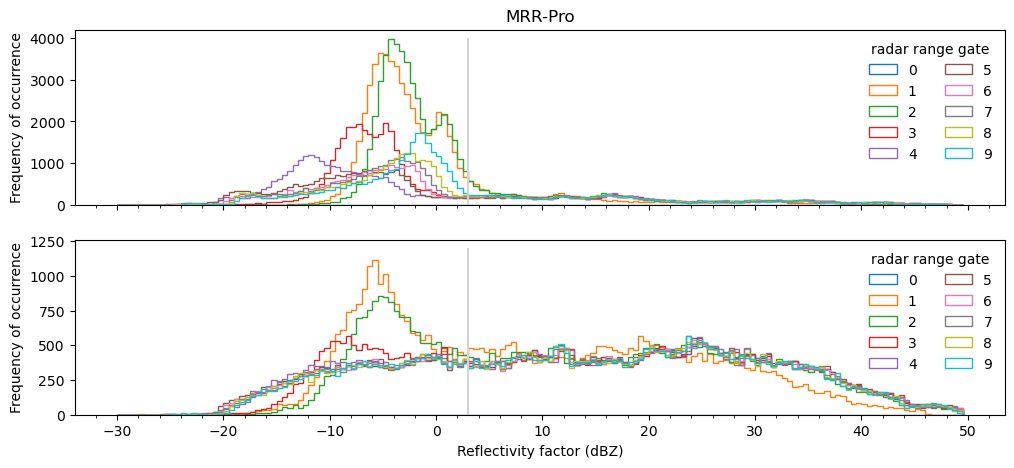

In [60]:
fig, ax = plt.subplots(nrows=2, figsize=(12,5), sharex=True)

for rr in range(0,10):
    data.isel(range=rr).sel(time=slice('2024-08-18T00:00', '2024-08-22T18:00')).plot.hist(bins=np.arange(-30,50,.5), histtype='step', label=rr, ax=ax[0])
    data.isel(range=rr).sel(time=slice('2024-08-22T18:00', '2024-09-22T12:00')).plot.hist(bins=np.arange(-30,50,.5), histtype='step', label=rr, ax=ax[1])

for axi in ax:
    axi.set_title('')
    axi.set_ylabel('Frequency of occurrence')
    axi.legend(ncols=2, frameon=False, title='radar range gate')
    #axi.set_ylim(0,4000)
    axi.set_xlabel('')
    axi.xaxis.set_minor_locator(AutoMinorLocator(5))

ax[0].vlines(3, 0, 4000, color='lightgray')
ax[1].vlines(3, 0, 1200, color='lightgray')
ax[0].set_title('MRR-Pro: until 22 August, 2024')
ax[1].set_title('MRR-Pro: from 22 August, 2024')
ax[1].set_xlabel('Reflectivity factor (dBZ)')


plt.savefig('MRR_Ze_lowest_radar_range_gate.png')

Ze threshold set to 3 dBZ

## Create rain flag

In [ ]:
# Create a mask: 1 for finite values, 0 for NaNs
finite_mask = xr.where(data.isel(range=3) > 3, 1, 0)

# Create a Dataset with the mask as a new variable
dataset = xr.Dataset({"rain_flag": finite_mask})

# add attribute to variable
dataset['rain_flag'].attrs['note'] = '1 in case of rain'

## Add global attributes

In [19]:
global_attrs = config['global_attrs']
global_attrs

{'title': 'surface rain flag from Micro Rain Radar',
 'summary': 'Flag for rain occurence retrieved from the Micro Rain Radar measurement. Therefore, the observed reflectivity in secondlowest radar range gate (120m)?',
 'creator_name': 'Andreas Foth',
 'creator_email': 'andreas.foth@uni-leipzig.de',
 'license': '?',
 'project': 'BOWTIE',
 'platform': 'RV METEOR',
 'source': '',
 'history': '',
 'references': '',
 'processing_level': '',
 'institution': 'Leipzig Institute for Meteorology, Leipzig University',
 'instrument': 'METEK MRR Pro 1.2.5, ID: MRRPro27, METEK Serial Number:  0511107367, Software:  MRR Pro 1.2.5',
 'creator_id': 'ORCiD: 0000-0002-1164-3576',
 'convention': 'CF/Radial'}

In [22]:
for key in global_attrs:
    dataset.attrs[key] = global_attrs[key]
    #print(global_attrs[key])

NameError: name 'dataset' is not defined

## Write dataset into netCDF

In [ ]:
dataset.to_netcdf('mrr_rainflag.nc')

In [10]:
data0

<xarray.Dataset> Size: 511MB
Dimensions:                 (range: 128, sweep: 1, time: 3600, n_spectra: 128,
                             spectrum_n_samples: 64)
Coordinates:
  * range                   (range) float32 512B 126.0 136.0 ... 1.396e+03
  * time                    (time) datetime64[ns] 29kB 2024-08-18T08:00:00.00...
    elevation               (time) float32 14kB ...
    azimuth                 (time) float32 14kB ...
Dimensions without coordinates: sweep, n_spectra, spectrum_n_samples
Data variables: (12/31)
    volume_number           int32 4B ...
    time_coverage_start     |S128 128B ...
    time_coverage_end       |S128 128B ...
    time_reference          |S128 128B ...
    instrument_type         |S128 128B ...
    transfer_function       (range) float64 1kB ...
    ...                      ...
    ML                      (time, range) float64 4MB ...
    SNR                     (time, range) float32 2MB ...
    index_spectra           (time, range) float64 4MB ...
    spectrum_raw            (time, n_spectra, spectrum_n_samples) float64 236MB ...
    N                       (time, n_spectra, spectrum_n_samples) float64 236MB ...
    D                       (n_spectra, spectrum_n_samples) float64 66kB ...
Attributes:
    Conventions:      CF/Radial
    version:          1.3
    title:            METEK MRR Pro 1.2.5 Data
    institution:      
    references:       
    source:           
    history:          
    comment:          Leipzig Main Institute Building
    instrument_name:  METEK MRR Pro 1.2.5, ID: MRRPro27, METEK Serial Number:...
    site_name:        LIM
    field_names:      Za,Z,Zea,Ze,RR,LWC,PIA,VEL,WIDTH,SNR,spectrum_reflectiv...

In [87]:
global_attrs = {
    'title': 'surface rain flag from Micro Rain Radar',
    'summary': 'Flag for rain occurence retrieved from the Micro Rain Radar measurement. Therefore, the observed reflectivity in secondlowest radar range gate (120m)?',
    'creator_name': 'Andreas Foth',
    'creator_email': 'andreas.foth@uni-leipzig.de',
    'license': '?',

    'project': 'BOWTIE',
    'platform': 'RV METEOR',
    'source': '',
    'history': '',
    'references': '',
    'processing_level': '',
    'institution': 'Leipzig Institute for Meteorology, Leipzig University',
    'instrument': 'METEK MRR Pro 1.2.5, ID: MRRPro27, METEK Serial Number:  0511107367, Software:  MRR Pro 1.2.5',
    'creator_id': 'ORCiD: 0000-0002-1164-3576',
    'convention': 'CF/Radial',
}

In [88]:
xr.open_dataset('20250130_leipzig-lim_chm15k_7d8e0258.nc')

<xarray.Dataset> Size: 71MB
Dimensions:             (range: 1024, time: 5760)
Coordinates:
  * range               (range) float32 4kB 7.492 22.48 ... 1.532e+04 1.534e+04
  * time                (time) datetime64[ns] 46kB 2025-01-30T00:00:10.000000...
Data variables:
    calibration_factor  float32 4B ...
    beta_raw            (time, range) float32 24MB ...
    zenith_angle        float32 4B ...
    beta                (time, range) float32 24MB ...
    beta_smooth         (time, range) float32 24MB ...
    height              (range) float32 4kB ...
    wavelength          float32 4B ...
    latitude            float32 4B ...
    longitude           float32 4B ...
    altitude            float32 4B ...
Attributes: (12/16)
    Conventions:                  CF-1.8
    cloudnetpy_version:           1.69.2
    file_uuid:                    28581ef0-ac16-4f65-9228-0206f9747a60
    cloudnet_file_type:           lidar
    title:                        CHM15k ceilometer from Leipzig LIM
    year:                         2025
    ...                           ...
    source:                       Lufft CHM15k
    serial_number:                CHM200114
    references:                   https://doi.org/10.21105/joss.02123
    pid:                          https://hdl.handle.net/21.12132/1.28581ef0a...
    cloudnet_processing_version:  2.49.2
    instrument_pid:               https://hdl.handle.net/21.12132/3.7d8e02584...